In [1]:
import numpy as np
import pandas as pd
import glob
import os
from skimage.measure import regionprops
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
from tifffile import imread

file_path = "G:/Shared drives/rAAV HVA2V1 anatomy"

mouse_id = ["retr02", "retr04", "retr07", "retr08", "retr12", "retr13", "retr14", "retr15", "retr16", "retr17", "retr18", "retr19", "retr20", "retr21", "retr22", "retr23", "retr24", "retr25", "retr26", "retr27"]
area = ["LM", "RL", "LM", "LM", "RL", "RL", "LM", "LM", "RL", "PM", "PM", "LM", "RL", "RL", "PM", "PM", "LM", "PM", "RL", "LM"]
rearing = ["NR", "NR", "NR", "DR", "NR", "NR", "NR", "DR", "DR", "NR", "NR", "DR", "DR", "DR", "DR", "NR", "NR", "DR", "DR", "DR"]

d = {"mouse_id" : mouse_id, "area" : area, "rearing" : rearing}
df = pd.DataFrame(data=d)
centroids, num_cells, LM_mag, RL_mag, PM_mag, NV_mag = [], [], [], [], [], []
for ms in df.itertuples(index=False):
    # Find paths to through-skull map and V1 cellpose data.
    curr_path = "{0}/{1}_{2}_{3}/".format(file_path, ms[1], ms[2], ms[0])
    subdirs = sorted(glob.glob(curr_path + "*"))
    mapping_dir = subdirs[0]
    for subdir in subdirs[2:]:
        if len(glob.glob(subdir + "/*_processed.npy")):
            cell_dir = subdir
    # Load cellpose data and get centroids.
    cell_file = glob.glob(cell_dir + "/*_processed.npy")
    cell_data = np.load(cell_file[0], allow_pickle=True)
    cell_dict = cell_data.item()
    masks = cell_dict["masks"]
    regions = regionprops(masks)
    temp_centroids  = []
    for region in regions:
        temp_centroids.append(region.centroid)
    centroids.append(pd.DataFrame(temp_centroids, columns=["Z", "Y", "X"]))
    num_cells.append(len(temp_centroids))
    # Segment HVAs if not already done.
    area_list = ["LM", "RL", "PM", "VI", "WD"]
    # matplotlib.use("Qt5Agg")
    refframe = imread(mapping_dir + "/refframe.tif").squeeze()
    signmap = np.loadtxt(mapping_dir + "/signmap.csv")
    # Create dictionary for storing visual area boundary coordinates.
    area_coords = dict(zip(area_list, [None]*len(area_list)))
    for area_num,area in enumerate(area_list):
        fig, ax = plt.subplots()
        ax.imshow(refframe, cmap="gray")
        ax.imshow(signmap, cmap="RdBu_r", clim=[-1,1], alpha=0.3)
        # Plot previously segmented areas to avoid selecting overlapping regions.
        if area_num > 0:
            for prev_area in area_list[:area_num]:
                ax.plot(area_coords[prev_area][:, 0], 
                        area_coords[prev_area][:, 1], 
                        color="k", linewidth=3)
        ax.set_title("Select Region for {ar}:".format(ar=area), fontsize=20)
        ax.axis("off")
        fig.set_size_inches(12, 12)
        # If segmentation coordinates are already saved for this area, use those.
        # Otherwise, get user input.
        if os.path.exists(mapping_dir + "/{ar}.csv".format(ar=area)):
            area_coords[area] = np.loadtxt(mapping_dir + "/{ar}.csv".format(ar=area))
        else:
            curr_input = plt.ginput(n=-1, timeout=-1)
            curr_input = np.array(curr_input)
            curr_input = np.append(curr_input, [curr_input[0,:]], axis=0)
            area_coords[area] = curr_input
            np.savetxt(mapping_dir + "/{ar}.csv".format(ar=area), curr_input)
        plt.close()
    # Get average magnitude in each HVA.
    avg_mag = np.loadtxt(mapping_dir + "/avg_mag_dff.csv")
    for area, maglst in zip(area_list, [LM_mag, RL_mag, PM_mag]):
        area_mask = np.full((512, 512), False)
        # Find points contained in current area boundary.
        area_path = mplPath.Path(area_coords[area])
        for row in range(area_mask.shape[0]):
            for col in range(area_mask.shape[1]):
                area_mask[row, col] = area_path.contains_point([col, row], radius=0.001) or area_path.contains_point([col, row], radius=-0.001)
        area_mag = np.nanmean(avg_mag[area_mask])
        maglst.append(area_mag)
    # Find points contained in current area boundary.
    NV_mask = np.full((512, 512), False)
    area_path = mplPath.Path(area_coords["NV"])
    for row in range(NV_mask.shape[0]):
        for col in range(NV_mask.shape[1]):
            NV_mask[row, col] = area_path.contains_point([col, row], radius=0.001) or area_path.contains_point([col, row], radius=-0.001)
    WI_mask = np.full((512, 512), False)
    area_path = mplPath.Path(area_coords["WI"])
    for row in range(WI_mask.shape[0]):
        for col in range(WI_mask.shape[1]):
            WI_mask[row, col] = area_path.contains_point([col, row], radius=0.001) or area_path.contains_point([col, row], radius=-0.001)
    area_mask = WI_mask - NV_mask          
    area_mag = np.nanmean(avg_mag[area_mask == 1])
    NV_mag.append(area_mag)
df["centroids"] = centroids
df["num_cells"] = num_cells
df["LM_mag"] = np.array(LM_mag)*100
df["RL_mag"] = np.array(RL_mag)*100
df["PM_mag"] = np.array(PM_mag)*100
df["NV_mag"] = np.array(NV_mag)*100

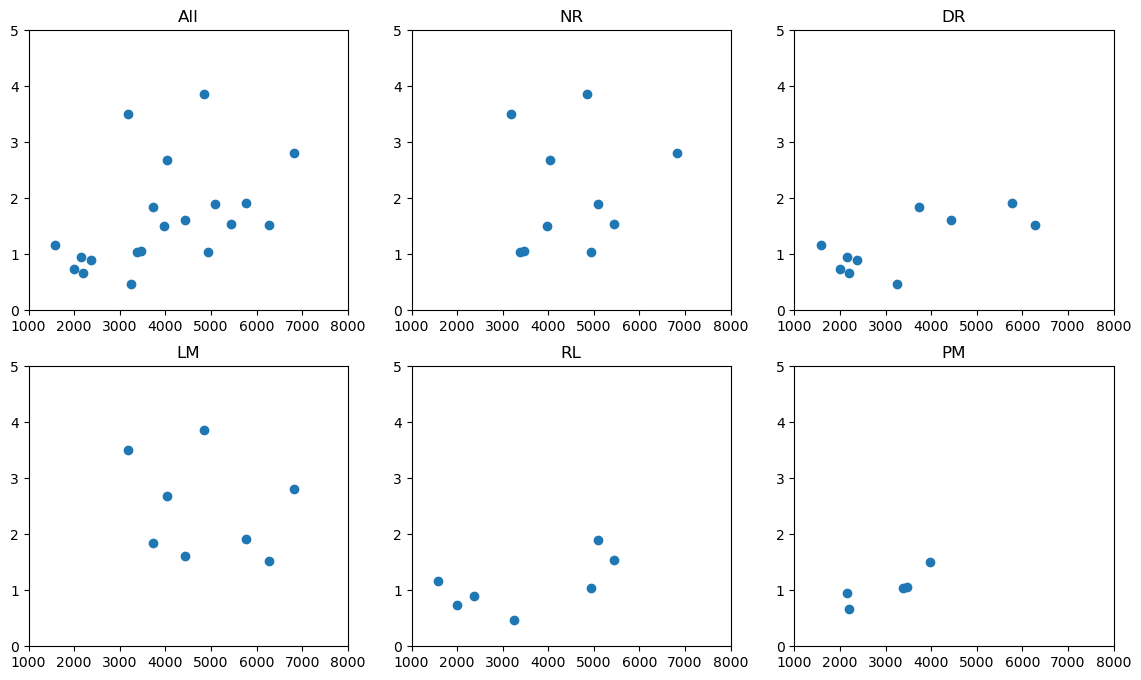

In [16]:
import matplotlib.pyplot as plt

all_vec, NR_vec, DR_vec, LM_vec, RL_vec, PM_vec = [], [], [], [], [], []
for ms in df.itertuples(index=False):
    if ms[1] == "LM":
        idx = 5
        LM_vec.append([ms[4], ms[idx]])
    elif ms[1] == "RL":
        idx = 6
        RL_vec.append([ms[4], ms[idx]])
    else:
        idx = 7
        PM_vec.append([ms[4], ms[idx]])
    all_vec.append([ms[4], ms[idx]])
    if ms[2] == "NR":
        NR_vec.append([ms[4], ms[idx]])
    elif ms[2] == "DR":
        DR_vec.append([ms[4], ms[idx]])
all_arr, NR_arr, DR_arr, LM_arr, RL_arr, PM_arr = np.array(all_vec), np.array(NR_vec), np.array(DR_vec), np.array(LM_vec), np.array(RL_vec), np.array(PM_vec)

fig, axs = plt.subplots(2, 3)
axs[0][0].scatter(all_arr[:, 0], all_arr[:, 1])
axs[0][0].set_xlim((1000, 8000))
axs[0][0].set_ylim((0, 5))
axs[0][0].set_title("All")
axs[0][1].scatter(NR_arr[:, 0], NR_arr[:, 1])
axs[0][1].set_xlim((1000, 8000))
axs[0][1].set_ylim((0, 5))
axs[0][1].set_title("NR")
axs[0][2].scatter(DR_arr[:, 0], DR_arr[:, 1])
axs[0][2].set_xlim((1000, 8000))
axs[0][2].set_ylim((0, 5))
axs[0][2].set_title("DR")
axs[1][0].scatter(LM_arr[:, 0], LM_arr[:, 1])
axs[1][0].set_xlim((1000, 8000))
axs[1][0].set_ylim((0, 5))
axs[1][0].set_title("LM")
axs[1][1].scatter(RL_arr[:, 0], RL_arr[:, 1])
axs[1][1].set_xlim((1000, 8000))
axs[1][1].set_ylim((0, 5))
axs[1][1].set_title("RL")
axs[1][2].scatter(PM_arr[:, 0], PM_arr[:, 1])
axs[1][2].set_xlim((1000, 8000))
axs[1][2].set_ylim((0, 5))
axs[1][2].set_title("PM")
fig.set_size_inches(14, 8)
plt.show(block=False)

In [ ]:
import seaborn as sns
#     fig, ax = plt.subplots()
#     hist_ax = sns.histplot(data=centroids, x="X", y="Y", stat="count", cbar=True, binwidth=30) # , vmin=0, vmax=40
#     ax.set_xlim((0, 796))
#     ax.set_ylim((0, 900))
#     ax.set_aspect(1)
#     ax.set_yticks([])
#     ax.set_xticks([])
#     ax.set_xlabel("")
#     ax.set_ylabel("")
#     ax.set_title(exp)